# **Performace measurements:**
In this notebook we measure the retrieval performance of the image search engine using the features taken from the test set.
The metric is the mAP, that averages the AP@k of a set of queries.

The performed steps:
- Features extraction of test set images with both MobileNetV2 pretrained model and our fine tuned model.
- Creation of two indexes using the features extracted with the two models each.
- Evaluation of the mAP for the two models, using a K parameter, used to compute the AP@k, and a set of queries taken from the test set.





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=33c3a32340f810311045755caefb9c6f111a0fe49e716adac999224362197b77
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
#retrieve test set

!cp '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/trainings/training_03/test.zip' .
!unzip -q test.zip
!rm test.zip

In [ ]:
%cd "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/notebooks"

/content/gdrive/.shortcut-targets-by-id/1Lqbq3dboVPe48Cxj_XZyhRs54U4hXhEM/[MIRCV]FoodWebSearch/notebooks


In [ ]:
import import_ipynb
from utils import ids_and_labels_from_file
from utils import preprocess
from index_creation import Node as nd
from index_creation import VP_Tree as vp
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
import sklearn 
from sklearn import preprocessing
from PIL import Image, ImageDraw, ImageOps 
import numpy as np
from IPython.display import display
import os

# constants
SETS_DIR = '/content/test/'
BATCH_SIZE = 256
MODEL_PATH = '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/food_classifier.h5'
INDEX_DIR =  "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/"
INDEX_PATH_FT= "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/index_test_ft/"

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ' , device_name)

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from index_creation.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
GPU:  /device:GPU:0


# Compute AP at K

## Average precision at K 


$AP@k= \frac{1}{N(k)} \sum_{i=1}^{k} \frac{TPseen(i)}{i}$


$TP = true positives$

$N(k) = min(k,TPtotal)$

TPseen(i) = 0 if i° FALSE 1 if i° TRUE

## Mean Average Precision at K

the mAP is the mean of AP@K obtained from different queries

$mAP@k= \frac{1}{N} \sum_{i=1}^{N} AP@k_i$


In [ ]:
#compute AP@k
def compute_ap_at_k(ranked_relevance, k):
  #ranked_relevance is a boolean array of dim k. true if retrieved element is relevant for the query, false if not relevant 
  total_relevant_items = ranked_relevance.sum()

  # Precision@i for each query, i.e. the number of relevant items @i divided by i
  #cumsum [1,3,2]=>[1,4,6]
  prec_at_i = ranked_relevance.cumsum() / np.arange(1, k + 1) 

  # sum of prec_at_i only for relevant, divide for total number of relevant items 
  aps = (ranked_relevance * prec_at_i).sum() / total_relevant_items

  return aps

In [ ]:
#retrieve the class labels for each img_id in result_ids
def retrieve_classes(result_ids, tot_ids, img_id_class):
  labels = []
  for img_id in result_ids:
      [labels.append(item[1]) for item in img_id_class if item[0] == img_id]
  return labels

In [ ]:
def show_images(res_ids, res_dists, ranked_relevance, path):
  #load images from images names(ids)
  imgs=[]
  for name in res_ids:
    for root, dirs, files in os.walk(path):
      if name in files:
        elem = str(os.path.join(root, name))
        img=np.array(load_img(elem, target_size=(80,80,3)))   
        imgs.append(img)

  for i in range(len(imgs)):
    # add a red/green flag
    color = (0, 255, 0) if ranked_relevance[i] else (255, 0, 0)
    flag = np.full((4, 80, 3), fill_value=color, dtype=imgs[i].dtype)
    imgs[i] = np.concatenate((imgs[i], flag), axis=0)

    # resize
    imgs[i] = Image.fromarray(imgs[i]).convert('RGBA')

    # draw score
    draw = ImageDraw.Draw(imgs[i])
    draw.text((3, 80 - 12), f'{res_dists[i]:.2f}', anchor='lt', fill=(255, 255, 255, 255))

    # pad the image with transparency
    imgs[i] = ImageOps.expand(imgs[i], 5, fill=(0, 0, 0, 0))
    imgs[i] = np.array(imgs[i])

  image = np.concatenate(imgs, axis=1)  # concatenate results horizontally
  display(Image.fromarray(image))

In [ ]:
def evaluate_knn(queries, k, test_ids, test_features, vp_tree, img_id_class):
  aps=[]
  for query_index in queries:

    query_id = [test_ids[query_index]]
    query_features = test_features[query_index]
    
    #perform the knn search
    res_nn, res_dists = vp_tree.knn_search(k, query_features)  #[img_id, img_features], distance(query,img)
    res_ids= [element[0] for element in res_nn]

    ranked_labels = retrieve_classes(res_ids, test_ids, img_id_class) #retrieve the labels of topk results
    query_label = retrieve_classes(query_id, test_ids, img_id_class)[0] #retrieve query label
    
    # ranked_relevance is if the retrieved image is relevant for the query
    ranked_relevance = np.array([label==query_label for label in ranked_labels])

    #compute ap@k
    ap_k = compute_ap_at_k(ranked_relevance, k) 
    aps.append(ap_k)  #aps maintain ap@k for each query

    x = min(k, 15) #don't show more than 15 result in colab
    show_images(res_ids[:x], res_dists[:x], ranked_relevance[:x], SETS_DIR)

  #calculate mAP
  mean=np.mean(aps)
  print('AP@', k ,'for each Query: ', aps)
  print('mAP@', k ,':', mean) 

In [ ]:
def print_queries(queries,img_id_class,test_ids):
  imgs=[]
  for index in queries:
    name = test_ids[index]
    for root, dirs, files in os.walk(SETS_DIR):
      if name in files:
        elem = str(os.path.join(root, name))
        img=np.array(load_img(elem, target_size=(80,80,3)))   
        imgs.append(img)

  for i in range(len(imgs)):
    # resize
    imgs[i] = Image.fromarray(imgs[i]).convert('RGBA')
    # pad the image with transparency
    imgs[i] = ImageOps.expand(imgs[i], 2, fill=(0, 0, 0, 0))
    imgs[i] = np.array(imgs[i])

  image = np.concatenate(imgs, axis=1)  # concatenate results horizontally

  print('Queries:')
  queries_names = [img_id_class[i][0] for i in queries ]
  queries_labels = [img_id_class[i][1] for i in queries ]
  print('-Names: ', queries_names)
  print('-Labels: ',queries_labels)
  display(Image.fromarray(image))

In [ ]:
#test set dataset creation from the test directory( 101 classes 150 pictures each)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    SETS_DIR,
    labels='inferred',
    label_mode='int',
    shuffle=False,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

test_set = test_set.prefetch(buffer_size=BATCH_SIZE)

#apply the preprocess of keras on every tuple of the dataset
test_set = test_set.map(preprocess, deterministic=True)

Found 15150 files belonging to 101 classes.


In [ ]:
#extract features with the fine tuned model and the relative image names
model_finetuned = keras.models.load_model(MODEL_PATH)
model_finetuned = keras.models.Model(inputs=model_finetuned.input, outputs=model_finetuned.get_layer('dense_hidden').output)
ft_test_features = model_finetuned.predict(test_set, batch_size=BATCH_SIZE, verbose=1)
#we don't normalize the features. to contrain big featres in just 0,1 space gived bad performaces on the tree
ft_test_features = list(ft_test_features)

test_ids, labels, class_name = ids_and_labels_from_file(SETS_DIR)

#the index creation needs theese files
np.save('/content/ids.npy', test_ids)
np.save('/content/ft_features.npy', ft_test_features)

#extract features with the pretrained model and the relative image names
model_pretrained = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')
pt_test_features = model_pretrained.predict(test_set, batch_size=BATCH_SIZE, verbose=1)
pt_test_features = list(pt_test_features)

np.save('/content/pt_features.npy', pt_test_features)

60/60 [==============================] - 45s 605ms/step
Found 15150 files belonging to 101 classes.
60/60 [==============================] - 41s 674ms/step


In [ ]:

tot_classes=[]
for elem in class_name:
  for i in range(150):
    tot_classes.append(elem)  # all ordered classes of all images

img_id_class= list(zip(test_ids,tot_classes))  #tuple list of (image_id,image_class) 

In [ ]:
#build the index for features extracted with the fine tuned model
vp_tree_ft = vp("index_test_ft",height=10, disk_mode=True, leaves_path=INDEX_DIR)
vp_tree_ft.create_vptree('/content/ids.npy', '/content/ft_features.npy')

#build the index for features extracted with the pretrained model
vp_tree_pt = vp("index_test_pt",height=10, disk_mode=True, leaves_path=INDEX_DIR)
vp_tree_pt.create_vptree('/content/ids.npy', '/content/pt_features.npy')

#vp.save_vptree(INDEX_PATH_FT, vp_tree_ft)

Number of data: 15150
The max height of the tree is: 12
Tree is building
Building of the tree completed in: 222.40245962142944 s
Number of data: 15150
The max height of the tree is: 12
Tree is building
Building of the tree completed in: 320.4450008869171 s


Queries:
-Names:  ['633918.jpg', '3374230.jpg', '2189741.jpg', '2127723.jpg', '2537186.jpg']
-Labels:  ['baby_back_ribs', 'edamame', 'beignets', 'red_velvet_cake', 'onion_rings']


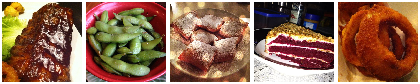

FINE TUNED MODEL:
Query answered in 1.7142925262451172  s


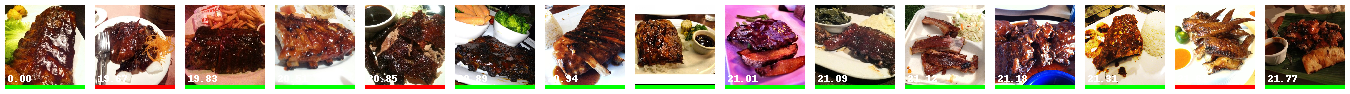

Query answered in 1.6984038352966309  s


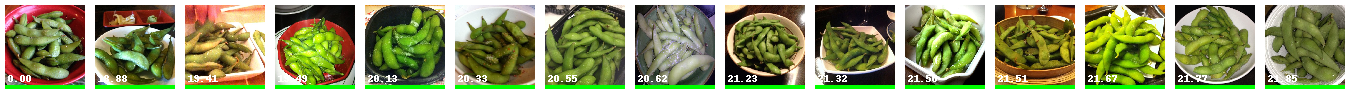

Query answered in 1.6988275051116943  s


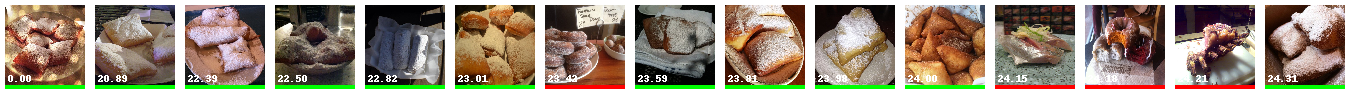

Query answered in 1.7044589519500732  s


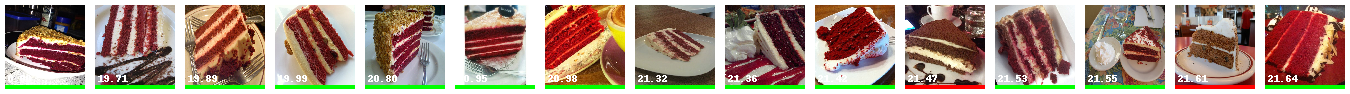

Query answered in 1.7113096714019775  s


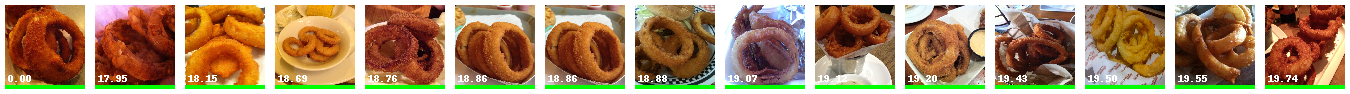

AP@ 20 for each Query:  [0.7836747465706743, 1.0, 0.8939555327713222, 0.9530971815573892, 1.0]
mAP@ 20 : 0.9261454921798771
MOBILE NET:
Query answered in 1.852936029434204  s


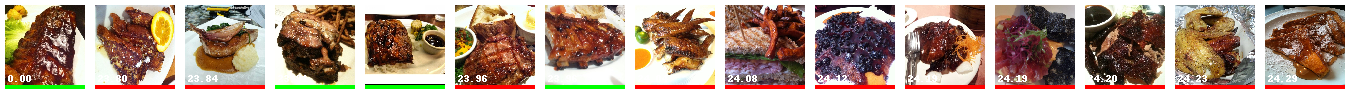

Query answered in 1.896913766860962  s


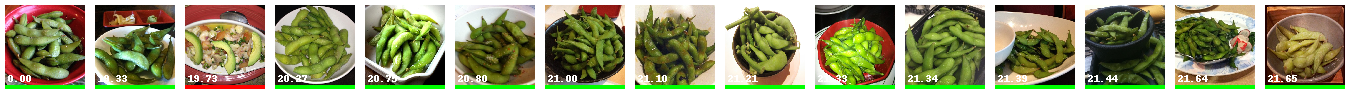

Query answered in 1.8417267799377441  s


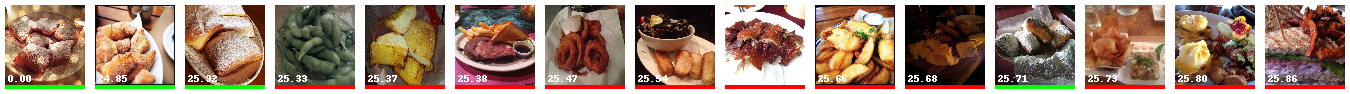

Query answered in 1.860764741897583  s


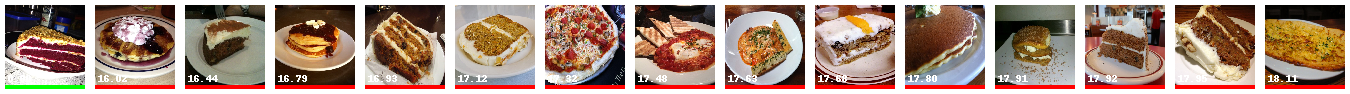

Query answered in 1.8350002765655518  s


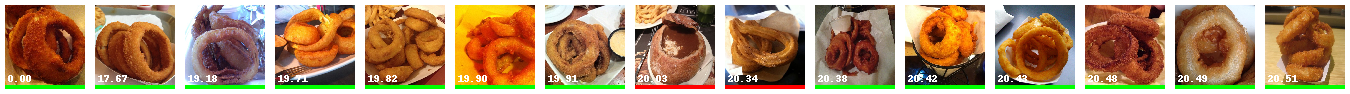

AP@ 20 for each Query:  [0.5967857142857143, 0.8993620918221021, 0.8333333333333333, 0.55, 0.9048963291610351]
mAP@ 20 : 0.7568754937204369


In [ ]:
K = 20
queries=[278,5053,951,12496,10264]

print_queries(queries,img_id_class,test_ids)

print('FINE TUNED MODEL:')
#evaluate knnsearch on the finetuned model 
evaluate_knn(queries, K, test_ids, ft_test_features, vp_tree_ft, img_id_class)

print('MOBILE NET:')
#evaluate knnsearch on the pretrained MobileNet model
evaluate_knn(queries, K, test_ids, pt_test_features, vp_tree_pt, img_id_class)